In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import http.client, urllib.request, urllib.parse, urllib.error, base64
# import config
import quickstart

In [2]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [28]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [29]:
csv = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
csv.GetContentFile('analysis_bbl.csv')  

df = pd.read_csv('analysis_bbl.csv')

In [32]:
# load codebook        
codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')  

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

/opt/homebrew/anaconda3/envs/geo_env/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0,0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0,0
2,totpop,total population,Census ACS,NaN,1,1
3,popdens,total population per square mile,Census ACS,NaN,1,1
4,areasqmile,area,Census ACS,NaN,1,1


In [33]:
predictors_full = codebk.loc[codebk["Include_Box"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2            totpop
3           popdens
4        areasqmile
5             males
6           females
           ...     
164    bldgclass_A2
165    bldgclass_A0
166    bldgclass_A6
167    bldgclass_A8
168    bldgclass_CM
Name: Variable, Length: 150, dtype: object

In [34]:
csv = df
csv.shape[0]
csv = csv.dropna()
csv.shape[0]

765026

In [35]:
X = csv.loc[:, predictors_full]
Y = csv[["vacate_ind"]]

In [43]:
# from sklearn import preprocessing
# X_scaled = preprocessing.scale(X)
# X=X_scaled
# print(pd.DataFrame(X).head())

In [36]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
resultsScaled = min_max_scaler.fit_transform(X)
X = resultsScaled

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90)

In [38]:
X_hadFires = pd.DataFrame(X_train[Y_train["vacate_ind"] == 1])
X_noFires = pd.DataFrame(X_train[Y_train["vacate_ind"] == 0])
X_noFires = X_noFires

Y_hadFires = Y_train.loc[Y_train["vacate_ind"] == 1, "vacate_ind"]
Y_noFires = Y_train.loc[Y_train["vacate_ind"] == 0, "vacate_ind"]

X_train_sub = pd.concat([X_hadFires, X_noFires], axis=0)
Y_train_sub = pd.concat([Y_hadFires, Y_noFires], axis=0)
Y_train_sub.shape

(512567,)

In [39]:
#from sklearn import svm
from sklearn.svm import LinearSVC
clf = LinearSVC(tol=1e-1, random_state=0)

In [40]:
clf.fit(X_train_sub, np.asarray(Y_train_sub))

LinearSVC(random_state=0, tol=0.1)

In [49]:
correct=1.0*(clf.predict(X_test) == np.asarray(Y_test).reshape(1,X_test.shape[0])).sum()/len(Y_test)
print("Out of sample, linear model successfully predicts {} percent of the data".format((correct)))

Out of sample, linear model successfully predicts 0.9965222075663771 percent of the data


In [50]:
from sklearn import metrics
preds = clf.predict(X_test)
# X_train, X_test, Y_train, Y_test
targs = Y_test
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))
test_preds = preds

accuracy:  0.9965222075663771
precision:  0.4090909090909091
recall:  0.010297482837528604
f1:  0.020089285714285712
area under curve (auc):  0.5051229052202628


In [51]:
# preds = clf.predict(X)
# print(preds)
# values = pd.DataFrame(preds)
# values.to_csv('values1.csv')

[0. 0. 0. ... 0. 0. 0.]


In [52]:
# pred_prob_allbld = pd.concat([df.loc[:, ["boroct2010", "bbl"]], 
#                             pd.DataFrame(preds,
#                                         columns = ["prob_vacate_bl"])], axis = 1)
# pred_prob_allbld

,boroct2010,bbl,prob_vacate_bl
0,1018100,1012090027,0.0
1,1018100,1012090028,0.0
2,1018100,1012090037,0.0
3,1018100,1012090049,0.0
4,1018100,1012090051,0.0
...,...,...,...
765021,1002500,1001110100,0.0
765022,1001002,1003250001,0.0
765023,1001002,1003230001,0.0
765024,1002000,1003560001,0.0


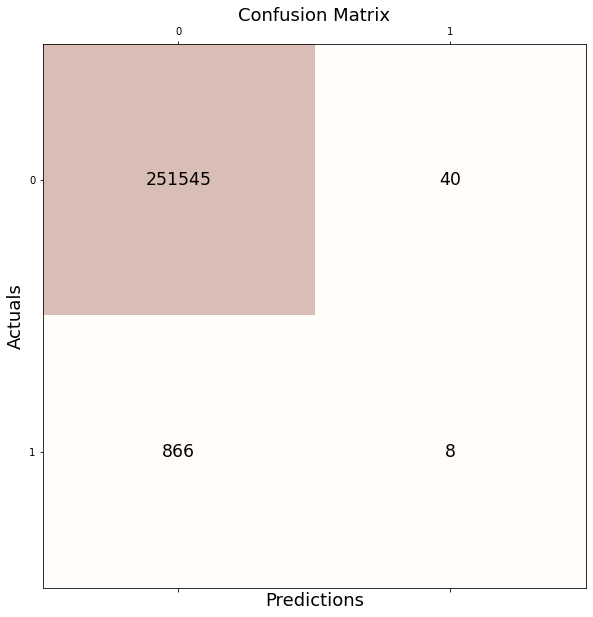

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# y_pred = clf.predict(X_test)
#
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = pl.subplots(figsize=(10, 10))
ax.matshow(conf_matrix, cmap=pl.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
pl.xlabel('Predictions', fontsize=18)
pl.ylabel('Actuals', fontsize=18)
pl.title('Confusion Matrix', fontsize=18)
pl.show()


### PART 2: Alarm Box Tracts

In [18]:
csv = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
# Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
csv.GetContentFile('analysis_box.csv')  

df = pd.read_csv('analysis_box.csv')

In [19]:
df_box = df
df_box['num_fire_ev_cat'] = pd.qcut(df_box["num_fire_ev"], 4, labels=False)
df_box['fire_ev_dummy'] = np.where(df_box['num_fire_ev_cat'] == 3, 1, 0)

In [20]:
predictors_full = codebk.loc[codebk["Include_Box"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2            totpop
3           popdens
4        areasqmile
5             males
6           females
           ...     
164    bldgclass_A2
165    bldgclass_A0
166    bldgclass_A6
167    bldgclass_A8
168    bldgclass_CM
Name: Variable, Length: 150, dtype: object

In [21]:
X = df_box.loc[:, predictors_full]
Y = df_box[["fire_ev_dummy"]]

In [22]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
resultsScaled = min_max_scaler.fit_transform(X)
X = resultsScaled

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90)

In [24]:
X_hadFires = pd.DataFrame(X_train[Y_train["fire_ev_dummy"] == 1])
X_noFires = pd.DataFrame(X_train[Y_train["fire_ev_dummy"] == 0])
X_noFires = X_noFires

Y_hadFires = Y_train.loc[Y_train["fire_ev_dummy"] == 1, "fire_ev_dummy"]
Y_noFires = Y_train.loc[Y_train["fire_ev_dummy"] == 0, "fire_ev_dummy"]

X_train_sub = pd.concat([X_hadFires, X_noFires], axis=0)
Y_train_sub = pd.concat([Y_hadFires, Y_noFires], axis=0)
Y_train_sub.shape

(7278,)

In [25]:
clf.fit(X_train_sub, np.asarray(Y_train_sub))

LinearSVC(random_state=0, tol=0.1)

In [62]:
correct=1.0*(clf.predict(X_test) == np.asarray(Y_test).reshape(1,X_test.shape[0])).sum()/len(Y_test)
print("Out of sample, linear model successfully predicts {} percent of the data".format((correct)))

Out of sample, linear model successfully predicts 0.839654210819855 percent of the data


In [26]:
from sklearn import metrics
preds = clf.predict(X_test)
# X_train, X_test, Y_train, Y_test
targs = Y_test
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))
test_preds = preds

accuracy:  0.839654210819855
precision:  0.7515432098765432
recall:  0.5405105438401776
f1:  0.6287927695287283
area under curve (auc):  0.7402738938940181
